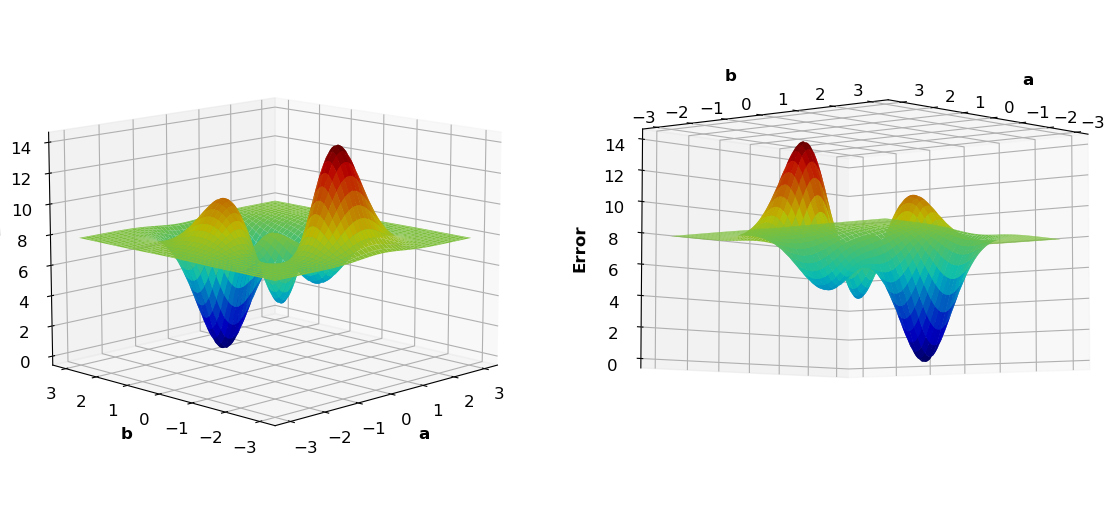

In [1]:
# MOST OF THIS CODE IS PROVIDED ONLY FOR REFERENCE, NOT TO BE FOCUSED ON IN THIS ASSIGNMENT. SCROLL DOWN TO THE 'OPTIMIZE' AND 'STEP' FUNCTIONS NEAR THE END.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
plt.rcParams.update({'font.size': 12})

def error(a, b):
   # defines the function from here https://www.youtube.com/watch?v=1i8muvzZkPw
    func = 3*(1 - a)**2*np.exp(-a**2-(b+1)**2) - 10*(a/5-a**3-b**5)*np.exp(-a**2-b**2) - (1/3)*np.exp(-b**2-(a+1)**2)
    return -func + 7.8

def get_xyz(f, a_limits=(-3, 3), b_limits=(-3, 3)):
    # sets up an xy grid with associated z values for 3d plotting
    a = np.linspace(a_limits[0], a_limits[1], num=100)
    b = np.linspace(b_limits[0], b_limits[1], num=100)

    mesh = np.meshgrid(a, b)
    z = np.vectorize(f)(mesh[0], mesh[1])

    return mesh[0], mesh[1], z

def fmt(x):
    return '{0:.{1}f}'.format(x, 1)

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

dark_jet = cmap_map(lambda x: x*0.75, matplotlib.cm.jet)

def _plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3), max=(0, 1.6)):
    # creates a 2d contour plot
    a, b, z = get_xyz(f, a_limits, b_limits)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()

    z = ax.contour(a, b, z, levels=22, cmap=dark_jet)
    ax.clabel(z, inline=True, fontsize=12,  fmt=fmt)

    ax.grid(True)
    ax.grid(True, which="minor", linestyle="dotted")

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.plot(*max, marker="*", markersize=18)

    return fig, ax

def plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3), max=(0, 1.6)):
    # plots the optimization landscape
    _, ax = _plot2d(f, a_limits, b_limits, max)
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    plt.show()

def plot3d(f, a_limits=(-3, 3), b_limits=(-3, 3)):
   # same, but plots in 3d with the same colorscheme
    a, b, z = get_xyz(f, a_limits, b_limits)

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    #ax = plt.axes(projection='3d')
    ax.view_init(12,-135)
    ax.plot_surface(a, b, z, cmap=dark_jet, edgecolor='none')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    ax.set_zlabel('Error',fontweight='bold')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(-5,40)
    ax.plot_surface(a, b, z, cmap=dark_jet, edgecolor='none')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    ax.set_zlabel('Error',fontweight='bold')
    
    plt.show()

def plot_optimization(move, start_a, start_b, stepsize, max_steps=1500):
    # given the starting points, creates a 2d contour plot, and error plot, and prints the end results
    a, b, errors = optimize(move, start_a, start_b, stepsize=stepsize, max_steps=1500)
    
    fig, ax = _plot2d(error)
    ax.plot(a, b, marker='o',  markersize=3, color='gray')
    ax.plot(start_a, start_b, marker='o',  markersize=9, color='green')
    ax.plot(a[-1], b[-1], marker='v',  markersize=9, color='black')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    plt.show()
    print("Final location (a,b) =", (round(a[-1],2),round(b[-1],2)))
    print("Final value of Error(a,b) =", round(errors[-1],3))
    
    plt.xlabel('Steps')
    plt.ylabel('Error')
    plt.plot(errors, marker='.')
    plt.show()
    
### THE FUNCTIONS BELOW SHOULD BE THE FOCAL POINT OF YOUR ANALYSIS

def step(a, b, stepsize):
    # how to take a step
    current_error = error(a, b)

    if error(a + stepsize, b) < current_error:
        a = a + stepsize
    elif error(a, b + stepsize) < current_error:
        b = b + stepsize
    elif error(a - stepsize, b) < current_error:
        a = a - stepsize
    elif error(a, b - stepsize) < current_error:
        b = b - stepsize
  
    return a, b

def optimize(move, start_a, start_b, stepsize, max_steps=150):
    # takes defined "move" function, and implements an optimization run
    all_a = [start_a]
    all_b = [start_b]
    all_error = [error(start_a,start_b)]

    for i in range(max_steps):
        a, b = move(start_a, start_b, stepsize)
        
        if a == start_a and b == start_b:
            break
    
        start_a, start_b = a, b

        all_a.append(start_a)
        all_b.append(start_b)
        all_error.append(error(start_a,start_b))

    return all_a, all_b, all_error

plot3d(error)

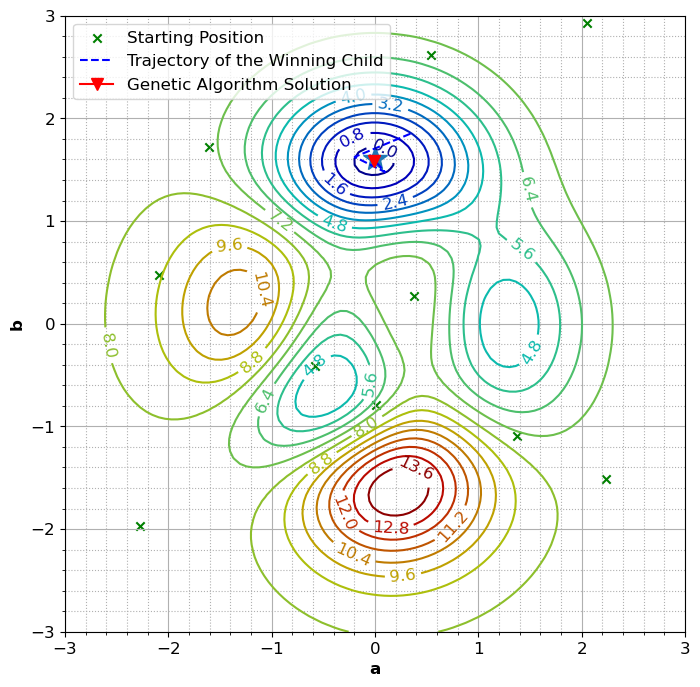

In [2]:
import random
import matplotlib.pyplot as plt

def initialize_population(population_size):
    """
    Initialize a population of random individuals.

    Parameters:
    - population_size (int): Number of individuals in the population.

    Returns:
    - list: List of tuples representing the initial population's loc.
    """
    return [(random.uniform(-3, 3), random.uniform(-3, 3)) for _ in range(population_size)]

def evaluate_fitness(population):
    """
    Evaluate the fitness of each individual in the population.

    Parameters:
    - population (list): List of tuples representing the population.

    Returns:
    - list: List of fitness scores for each individual.
    """
    return [error(a, b) for a, b in population]

def select_parents(population, fitness, num_parents):
    """
    Select the top individuals based on their fitness scores as parents for reproduction.

    Parameters:
    - population (list): List of tuples representing the population.
    - fitness (list): List of fitness scores for each individual.
    - num_parents (int): Number of parents to select.

    Returns:
    - list: List of tuples representing the selected parents.
    """
    selected_indices = sorted(range(len(fitness)), key=lambda i: fitness[i])[:num_parents]
    return [population[i] for i in selected_indices]

def crossover(parents, num_offspring):
    """
    Perform crossover to generate offspring from selected parents.

    Parameters:
    - parents (list): List of tuples representing the selected parents.
    - num_offspring (int): Number of offspring to generate.

    Returns:
    - list: List of tuples representing the generated offspring.
    """
    offspring = []
    for _ in range(num_offspring):
        parent1, parent2 = random.sample(parents, 2)
        crossover_point = random.uniform(0, 1)
        offspring.append((crossover_point * parent1[0] + (1 - crossover_point) * parent2[0],
                          crossover_point * parent1[1] + (1 - crossover_point) * parent2[1]))
    return offspring

def mutate(individual, mutation_rate):
    """
    Apply mutation to an individual.

    Parameters:
    - individual (tuple): Tuple representing an individual.
    - mutation_rate (float): Rate of mutation.

    Returns:
    - tuple: Mutated individual.
    """
    return (individual[0] + mutation_rate * random.uniform(-1, 1),
            individual[1] + mutation_rate * random.uniform(-1, 1))

def genetic_algorithm(population_size, num_generations, num_parents, num_offspring, mutation_rate):
    """
    Perform a genetic algorithm optimization.

    Parameters:
    - population_size (int): Number of individuals in the population.
    - num_generations (int): Number of generations to run the algorithm.
    - num_parents (int): Number of parents selected for reproduction.
    - num_offspring (int): Number of offspring generated through crossover.
    - mutation_rate (float): Rate of mutation.

    Returns:
    - tuple: Tuple containing the initial population, final solution, and a list of best solutions per generation.
    """
    initial_population = initialize_population(population_size)
    population = initial_population.copy()
    best_solution_per_generation = []

    for generation in range(num_generations):
        fitness = evaluate_fitness(population)
        parents = select_parents(population, fitness, num_parents)
        offspring = crossover(parents, num_offspring)
        mutated_offspring = [mutate(child, mutation_rate) for child in offspring]
        population = parents + mutated_offspring

        # Track the best solution at each generation
        final_fitness = evaluate_fitness(population)
        best_index = min(range(len(final_fitness)), key=lambda i: final_fitness[i])
        best_solution_per_generation.append(population[best_index])

    # After the last generation, find the best individual
    final_fitness = evaluate_fitness(population)
    best_index = min(range(len(final_fitness)), key=lambda i: final_fitness[i])
    final_solution = population[best_index]

    return initial_population, final_solution, best_solution_per_generation

def plot_optimization_genetic(population_size, num_generations, num_parents, num_offspring, mutation_rate):
    """
    Plot the optimization process using a genetic algorithm.

    Parameters:
    - population_size (int): Number of individuals in the population.
    - num_generations (int): Number of generations to run the algorithm.
    - num_parents (int): Number of parents selected for reproduction.
    - num_offspring (int): Number of offspring generated through crossover.
    - mutation_rate (float): Rate of mutation.

    Returns:
    - None
    """
    initial_population, final_solution, best_solution_per_generation = genetic_algorithm(population_size, num_generations, num_parents, num_offspring, mutation_rate)

    # Plot the 2D landscape
    _, ax = _plot2d(error)
    # Plot the starting position
    initial_positions = list(zip(*initial_population))
    ax.scatter(initial_positions[0], initial_positions[1], marker='x', color='green', label='Starting Position')

    # Plot the trajectory of the winning child
    trajectory = list(zip(*best_solution_per_generation))
    ax.plot(trajectory[0], trajectory[1], linestyle='--', color='blue', label='Trajectory of the Winning Child')

    # Plot the final solution
    ax.plot(final_solution[0], final_solution[1], marker='v', markersize=9, color='red', label='Genetic Algorithm Solution')

    ax.legend()
    ax.set_xlabel('a', fontweight='bold')
    ax.set_ylabel('b', fontweight='bold')
    plt.show()

plot_optimization_genetic(population_size=10, num_generations=200, num_parents=50, num_offspring=30, mutation_rate=0.1)
